In [50]:
# import necessary modules

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from feature_engine.outliers import Winsorizer
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


Set up a connection to a cloud-based database using Python. We used a zip file named 'secure-connect-ml-projects.zip', which contains all the necessary configuration settings. The PlainTextAuthProvider uses security credentials for the connection. After establishing the connection, we sent a query to the database to get the release version of the system. The version was then printed out, confirming that our connection and query execution were successful.

In [51]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

cloud_config= {
    'secure_connect_bundle': 'D:\secure-connect-ml-projects.zip'
}
auth_provider = PlainTextAuthProvider('ylHAUuutJalGrfaMhsAGyYGS', 'UrdCS4S7jOrnzxgmhazNOx2fRs4tly0E1Kynx6kdQZpUszkCZTTSkuli4-JA.Dx6sp7HT-XqUwAP2Eh1MDhov5KO.5ABJiTc7PRzWe++fEhQG3s8ZlJlhvGtqqXu,Fdg')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
    print(row[0])
else:
    print("An error occurred.")


4.0.0.6816


In [52]:
tables = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name='concrete_strength_prediction'")
for table in tables:
    print(table.table_name)


concrete_data


In [53]:
# check the rows in database

query = "SELECT COUNT(*) FROM concrete_strength_prediction.concrete_data"
rows = session.execute(query)

for row in rows:
    print(row)

Row(count=990)


In [54]:
# load data in dataframe 

query = "SELECT * FROM concrete_strength_prediction.concrete_data"

rows = session.execute(query)

df = pd.DataFrame(list(rows))

df.head(5)

,cement,concrete_compressive_strength,age,blast_furnace_slag,coarse_aggregate,fine_aggregate,fly_ash,superplasticizer,water
0,182,21.5,14,45.2,1059.4,780.7,122,8.2,170.2
1,237.5,26.26,7,237.5,932,594,0,0,228
2,212.5,26.31,14,0,1007.8,903.6,100.4,8.7,159.3
3,307,36.15,365,0,968,812,0,0,193
4,168,39.23,100,42.1,1058.7,780.1,163.8,5.7,121.8


#### EDA done in pervious notebook

In [55]:
# drop duplicate rows

df = df.drop_duplicates()

In [56]:
# make copy of df for further invistegition 

df1= df.copy()
df2 = df.copy()

In [57]:
df.dtypes

cement                           object
concrete_compressive_strength    object
age                               int64
blast_furnace_slag               object
coarse_aggregate                 object
fine_aggregate                   object
fly_ash                          object
superplasticizer                 object
water                            object
dtype: object

In [58]:
# change object features to float

columns_to_convert = ['cement', 'concrete_compressive_strength', 'blast_furnace_slag', 'coarse_aggregate', 'fine_aggregate', 'fly_ash', 'superplasticizer', 'water']

for column in columns_to_convert:
    df[column] = df[column].astype(float)


In [59]:
df.dtypes

cement                           float64
concrete_compressive_strength    float64
age                                int64
blast_furnace_slag               float64
coarse_aggregate                 float64
fine_aggregate                   float64
fly_ash                          float64
superplasticizer                 float64
water                            float64
dtype: object

In [60]:
# train test split

X = df.drop(['concrete_compressive_strength'], axis=1)
y = df['concrete_compressive_strength']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=9)

In [61]:
#XG boost

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)



# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_ypred_train = xgb_model.predict(X_train)
xgb_ypred_test = xgb_model.predict(X_test)

# Calculate metrics
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_ypred_test))
xgb_r2_train = r2_score(y_train, xgb_ypred_train)
xgb_r2_test = r2_score(y_test, xgb_ypred_test)

# Perform  k fold cross-validation on XGBoost Regression
k = 5 
kfold_XG = KFold(n_splits=k, random_state= 42, shuffle=True)
CV_score_XG = cross_val_score(xgb_model,X,y, scoring='r2', cv=kfold_XG)



print("XGBoost Regression (Train) - R^2:", xgb_r2_train)
print("XGBoost Regression (Test) - R^2:", xgb_r2_test)
print("XGBoost Regression (Test) - RMSE:", xgb_rmse_test)
print("XGBoost Regression CV Score :", CV_score_XG.mean())

XGBoost Regression (Train) - R^2: 0.9950141389372562
XGBoost Regression (Test) - R^2: 0.9285680528879587
XGBoost Regression (Test) - RMSE: 4.542211358519461
XGBoost Regression CV Score : 0.9285695411488856


In [62]:
X.columns

Index(['cement', 'age', 'blast_furnace_slag', 'coarse_aggregate',
       'fine_aggregate', 'fly_ash', 'superplasticizer', 'water'],
      dtype='object')

In [63]:
"""#Hyperparamater tuning
#Grid serch 

from sklearn.model_selection import GridSearchCV

# Define a parameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'lambda': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'n_estimators': [50,100,200,300,400,500],
    'max_depth': [2, 4, 6]
}

# Initialize an XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameter
print(grid_search.best_params_)"""

"#Hyperparamater tuning\n#Grid serch \n\nfrom sklearn.model_selection import GridSearchCV\n\n# Define a parameter grid\nparam_grid = {\n    'alpha': [0.001, 0.01, 0.1, 1, 10],\n    'lambda': [0.001, 0.01, 0.1, 1, 10],\n    'gamma': [0.001, 0.01, 0.1, 1, 10],\n    'n_estimators': [50,100,200,300,400,500],\n    'max_depth': [2, 4, 6]\n}\n\n# Initialize an XGBoost Regressor\nxgb_model = xgb.XGBRegressor(objective='reg:squarederror')\n\n# Initialize the GridSearchCV object\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)\n\n# Fit the GridSearchCV object to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameter\nprint(grid_search.best_params_)"

XGBoost Regression (Train) - R^2: 0.9818140411690465
XGBoost Regression (Test) - R^2: 0.929531254300285
XGBoost Regression (Test) - RMSE: 4.5114834181733485
XGBoost Regression CV Score : 0.9241035860106048


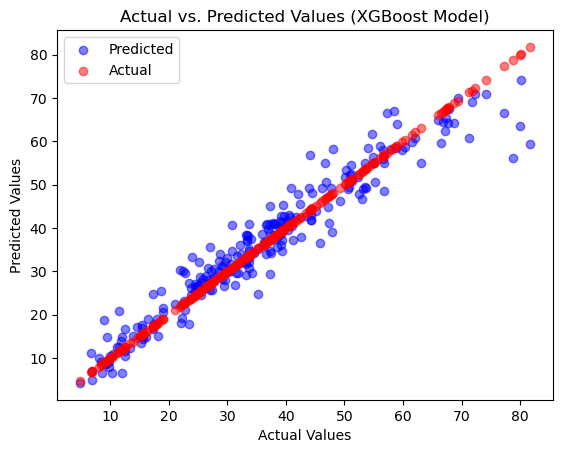

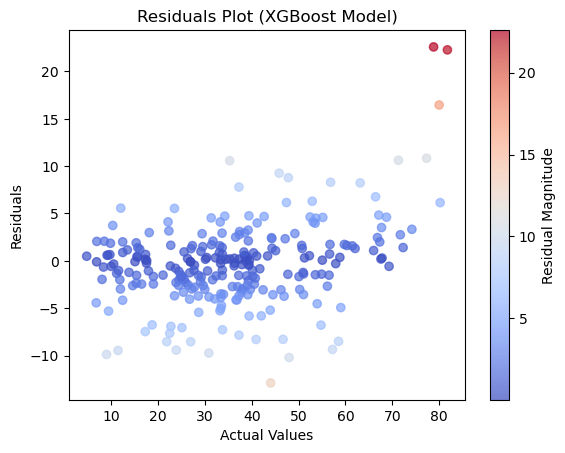

Approximately 78.23% of residuals are within one standard deviation of the mean.


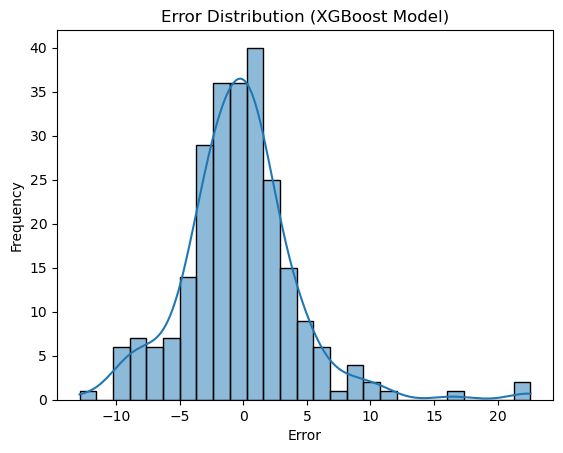

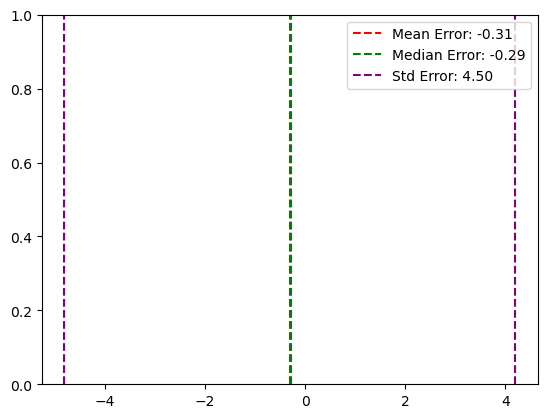

In [64]:
#XG boost remodeling

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, reg_alpha=0.1, reg_lambda=10, gamma=0.01, max_depth=4)


# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_ypred_train = xgb_model.predict(X_train)
xgb_ypred_test = xgb_model.predict(X_test)

# Calculate metrics
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_ypred_test))
xgb_r2_train = r2_score(y_train, xgb_ypred_train)
xgb_r2_test = r2_score(y_test, xgb_ypred_test)

# Perform  k fold cross-validation on XGBoost Regression
k = 5 
kfold_XG = KFold(n_splits=k, random_state= 42, shuffle=True)
CV_score_XG = cross_val_score(xgb_model,X,y, scoring='r2', cv=kfold_XG)



print("XGBoost Regression (Train) - R^2:", xgb_r2_train)
print("XGBoost Regression (Test) - R^2:", xgb_r2_test)
print("XGBoost Regression (Test) - RMSE:", xgb_rmse_test)
print("XGBoost Regression CV Score :", CV_score_XG.mean())


# Scatter plot for actual vs. predicted values on test set
plt.scatter(y_test, xgb_ypred_test, c='b', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='r', label='Actual', alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (XGBoost Model)")
plt.legend()
plt.show()


# Calculate residuals
residuals = y_test - xgb_ypred_test

# Define colors for bubbles based on the magnitude of residuals
colors = np.abs(residuals)

# Scatter plot for residuals
plt.scatter(y_test, residuals, c=colors, cmap='coolwarm', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot (XGBoost Model)")
plt.colorbar(label='Residual Magnitude')
plt.show()

# Calculate the mean and standard deviation of the residuals
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Calculate the percentage of residuals within one standard deviation of the mean
within_one_std = residuals[(residuals > mean_residuals - std_residuals) & (residuals < mean_residuals + std_residuals)]
percentage = len(within_one_std) / len(residuals) * 100

print(f"Approximately {percentage:.2f}% of residuals are within one standard deviation of the mean.")

# Error distribution plot
sns.histplot(residuals, kde=True)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (XGBoost Model)")
plt.show()




# Calculate central tendency
mean_error = np.mean(residuals)
median_error = np.median(residuals)

# Calculate spread
std_error = np.std(residuals)

# Display statistics
plt.axvline(mean_error, color='red', linestyle='--', label=f"Mean Error: {mean_error:.2f}")
plt.axvline(median_error, color='green', linestyle='--', label=f"Median Error: {median_error:.2f}")
plt.axvline(mean_error + std_error, color='purple', linestyle='--', label=f"Std Error: {std_error:.2f}")
plt.axvline(mean_error - std_error, color='purple', linestyle='--')

plt.legend()
plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Hybrid Model (Train) - R^2: 0.9833186417189904
Hybrid Model (Test) - R^2: 0.9351907752156532
Hybrid Model (Test) - RMSE: 4.326527894643483
Hybrid Model CV Score: 0.9290091276963839


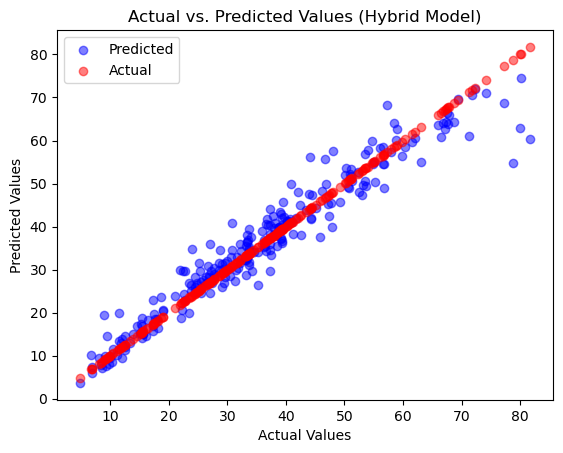

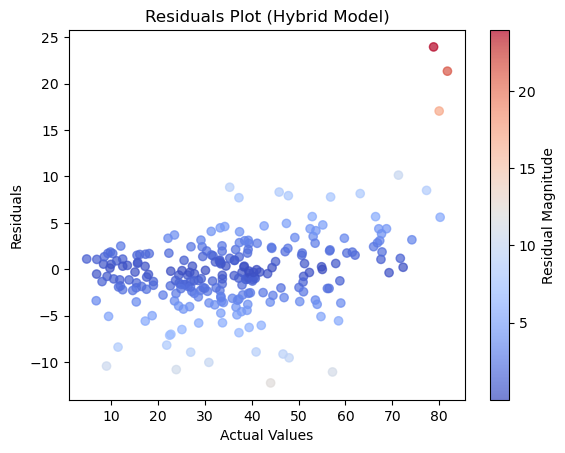

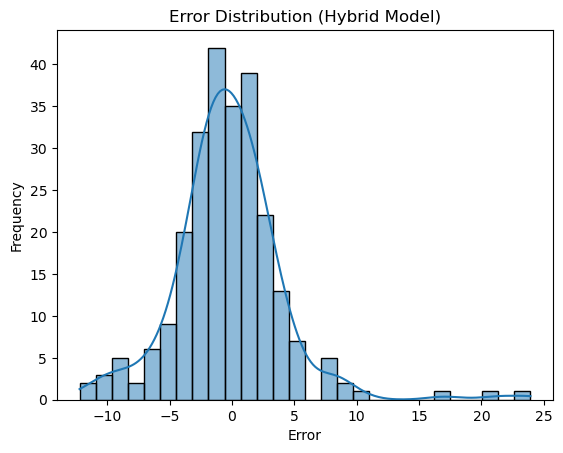

Approximately 79.44% of errors are within one standard deviation of the mean.


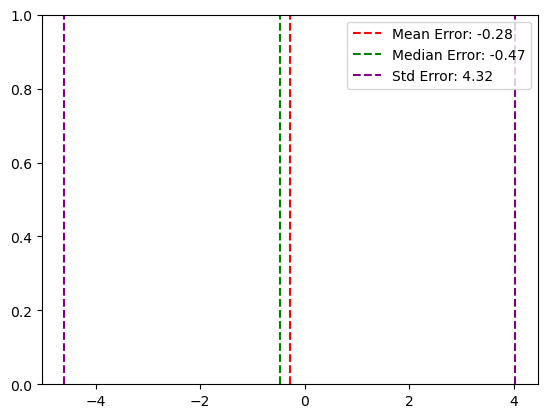

In [65]:
# XGBoost model
xgb_model2 = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, reg_alpha=0.1, reg_lambda=10, gamma=0.01, max_depth=4)

# Fit the XGBoost model
xgb_model2.fit(X_train, y_train)

# Make predictions with XGBoost
xgb_ypred_train = xgb_model2.predict(X_train)
xgb_ypred_test = xgb_model2.predict(X_test)

# LightGBM model
lgb_model2 = lgb.LGBMRegressor(
    boosting_type='gbdt',
    colsample_bytree=0.5,
    learning_rate=0.1,
    max_depth=4,
    min_data_in_leaf=10,
    min_split_gain=0.01,
    n_estimators=300,
    num_leaves=31,
    objective='regression',
    random_state=501,
    subsample=0.5)
# Fit the LightGBM model
lgb_model2.fit(X_train, y_train)

# Make predictions with LightGBM
lgb_ypred_train = lgb_model2.predict(X_train)
lgb_ypred_test = lgb_model2.predict(X_test)

# Combine predictions
hybrid_ypred_train = (xgb_ypred_train + lgb_ypred_train) / 2
hybrid_ypred_test = (xgb_ypred_test + lgb_ypred_test) / 2

# Calculate metrics for hybrid model
hybrid_rmse_test = np.sqrt(mean_squared_error(y_test, hybrid_ypred_test))
hybrid_r2_train = r2_score(y_train, hybrid_ypred_train)
hybrid_r2_test = r2_score(y_test, hybrid_ypred_test)

# Perform k-fold cross-validation on the hybrid model
k = 10
kfold_hybrid = KFold(n_splits=k, random_state=42, shuffle=True)
CV_scores_hybrid = cross_val_score(xgb_model, X, y, scoring='r2', cv=kfold_hybrid)

# Print metrics for the hybrid model
print("Hybrid Model (Train) - R^2:", hybrid_r2_train)
print("Hybrid Model (Test) - R^2:", hybrid_r2_test)
print("Hybrid Model (Test) - RMSE:", hybrid_rmse_test)
print("Hybrid Model CV Score:", CV_scores_hybrid.mean())


# Scatter plot for actual vs. predicted values on test set
plt.scatter(y_test, hybrid_ypred_test, c='b', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='r', label='Actual', alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Hybrid Model)")
plt.legend()
plt.show()

# Calculate residuals
residuals = y_test - hybrid_ypred_test

# Define colors for bubbles based on the magnitude of residuals
colors = np.abs(residuals)

# Scatter plot for residuals
plt.scatter(y_test, residuals, c=colors, cmap='coolwarm', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot (Hybrid Model)")
plt.colorbar(label='Residual Magnitude')
plt.show()




errors = y_test - hybrid_ypred_test

# Error distribution plot
sns.histplot(errors, kde=True)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (Hybrid Model)")
plt.show()

# Calculate the mean and standard deviation of the errors
mean_error = np.mean(errors)
std_error = np.std(errors)

# Calculate the percentage of errors within one standard deviation of the mean
within_one_std = errors[(errors > mean_error - std_error) & (errors < mean_error + std_error)]
percentage = len(within_one_std) / len(errors) * 100

print(f"Approximately {percentage:.2f}% of errors are within one standard deviation of the mean.")

# Calculate central tendency
mean_error = np.mean(errors)
median_error = np.median(errors)

# Calculate spread
std_error = np.std(errors)

# Display statistics
plt.axvline(mean_error, color='red', linestyle='--', label=f"Mean Error: {mean_error:.2f}")
plt.axvline(median_error, color='green', linestyle='--', label=f"Median Error: {median_error:.2f}")
plt.axvline(mean_error + std_error, color='purple', linestyle='--', label=f"Std Error: {std_error:.2f}")
plt.axvline(mean_error - std_error, color='purple', linestyle='--')

plt.legend()
plt.show()

In [67]:
import pickle

# Save models
pickle.dump(xgb_model2, open("xgb_model2.sav", "wb"))
pickle.dump(lgb_model2, open("lgb_model2.sav", "wb"))

In [ ]:
# Load models
xgb_model2_loaded = pickle.load(open("xgb_model2.sav", "rb"))
lgb_model2_loaded = pickle.load(open("lgb_model2.sav", "rb"))

# Make predictions with each model
xgb_ypred2 = xgb_model2_loaded.predict(X)
lgb_ypred2 = lgb_model2_loaded.predict(X)

# Average predictions
hybrid_ypred2 = (xgb_ypred2 + lgb_ypred2) / 2


In [ ]:
 #save model 2


filename = 'final_model.sav'
pickle.dump(xgb_model, open(filename,'wb'))



"#save model\n\nimport pickle\n\nfilename = 'final_model.sav'\npickle.dump(xgb_model, open(filename,'wb')) "

In [ ]:
#loding the save model2

loaded_model = pickle.load(open('final_model.sav', 'rb'))

"#loding the save model\n\nloaded_model = pickle.load(open('final_model.sav', 'rb')) "

In [ ]:
X.head()

,cement,age,blast_furnace_slag,coarse_aggregate,fine_aggregate,fly_ash,superplasticizer,water
0,182.0,14,45.2,1059.4,780.7,122.0,8.2,170.2
1,237.5,7,237.5,932.0,594.0,0.0,0.0,228.0
2,212.5,14,0.0,1007.8,903.6,100.4,8.7,159.3
3,307.0,365,0.0,968.0,812.0,0.0,0.0,193.0
4,168.0,100,42.1,1058.7,780.1,163.8,5.7,121.8
